In [1]:
## Imports
import pandas as pd
from scipy.sparse import csr_matrix
import random
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import math
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import ast

## import algorithm utils
import sys
import os
sys.path.append(os.path.abspath('../src'))
from utils.collaborative_filtering import evaluate_cf_model
from utils.two_towers import prepare_two_tower_data, train_two_tower_model, evaluate_two_tower_model

# keep track of time
import time
start_time = time.time()

In [2]:
## Basic setup
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
device='cuda' if torch.cuda.is_available() else 'cpu'

# Data Loading

In [3]:
## Get the relevant rows in the dataset
relevant_rows = list(range(0, 1373)) + list(range(5073, 6219))
len(relevant_rows)

2519

### Ratings Matrix

In [4]:
## Loading the ratings matrix
ratings_df = pd.read_csv("../dataset/sparse_ratings_matrix.csv")
ratings_df = ratings_df.iloc[relevant_rows].reset_index(drop=True)
ratings_df = ratings_df.drop(ratings_df.columns[0], axis=1)
ratings_df = ratings_df.fillna(0)

ratings_sparse_mat = csr_matrix(ratings_df.values)
rows, cols = ratings_sparse_mat.nonzero()

## Convert the non-zero values into a 1D array and shuffle the data
ratings = ratings_sparse_mat[rows, cols].A1
nonzero_data = [(int(r), int(c), int(v)) for r, c, v in zip(rows, cols, ratings)]
random.shuffle(nonzero_data)

In [5]:
## Split into training and validation sets
dataset_length = len(nonzero_data)
val_percentage = 0.2

train_last_idx = int((1-val_percentage) * dataset_length)

train_data = nonzero_data[:train_last_idx]
val_data = nonzero_data[train_last_idx:]

## Example of the training data
train_data[0] ## this will have the format of (image_id, user_id, rating)

(620, 3, -1)

In [6]:
## Changing the ratings matrix to binary
original_ratings_df = pd.read_csv("../dataset/sparse_ratings_matrix.csv")
original_ratings_df = original_ratings_df.iloc[relevant_rows].reset_index(drop=True)
original_ratings_df = original_ratings_df.drop(original_ratings_df.columns[0], axis=1)

# +1 if >=7
# –1 if <7
# 0 if nan
binary_ratings = original_ratings_df.applymap(
    lambda x: 1 if x >= 7
              else (-1 if pd.notna(x)
                    else 0)
)

# (Just in case any NaNs remain)
binary_ratings = binary_ratings.fillna(0)

bin_ratings_sparse = csr_matrix(binary_ratings.values)
rows_bin, cols_bin = bin_ratings_sparse.nonzero()

## Convert the non-zero values into a 1D array
ratings_bin = bin_ratings_sparse[rows_bin, cols_bin].A1

/var/folders/6z/9v5270311_7fxn3tgs2wh7bw0000gn/T/ipykernel_26872/1400366283.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  binary_ratings = original_ratings_df.applymap(


In [7]:
# Flatten to 1D and count occurrences of each value
values, counts = np.unique(binary_ratings.values.flatten(), return_counts=True)

# Zip into a dict for readability
distribution = dict(zip(values, counts))

print("Distribution of binary ratings:")
print(f"  -1 : {distribution.get(-1, 0)}")
print(f"   0 : {distribution.get( 0, 0)}")
print(f"  +1 : {distribution.get( 1, 0)}")

Distribution of binary ratings:
  -1 : 8905
   0 : 60503
  +1 : 6162


In [8]:
nonzero_data_bin = [(int(r), int(c), int(v)) for r, c, v in zip(rows_bin, cols_bin, ratings_bin)]
random.shuffle(nonzero_data_bin)

train_data_bin = nonzero_data_bin[:train_last_idx]
val_data_bin = nonzero_data_bin[train_last_idx:]

train_data_bin[0]

(1432, 5, -1)

### Embeddings Dataset

In [9]:
## Construct the item's embedding matrix
img_text_embeddings = pd.read_csv("../dataset/embeddings_final.csv")
img_text_embeddings = img_text_embeddings.iloc[relevant_rows].reset_index(drop=True)

embeddings_df = img_text_embeddings[['image_key', 'text_embedding', 'image_embedding']].copy()
embeddings_df['image_path'] = embeddings_df['image_key'].apply(lambda x: f"dataset/images/{x}.jpg")
embeddings_df = embeddings_df.drop(columns=['image_key'])

embeddings_df["text_embedding"] = embeddings_df["text_embedding"].apply(ast.literal_eval)
embeddings_df["image_embedding"] = embeddings_df["image_embedding"].apply(ast.literal_eval)
embeddings_df['combined_embedding'] = embeddings_df['text_embedding'] + embeddings_df['image_embedding']
embeddings_df.head(2)

,text_embedding,image_embedding,image_path,combined_embedding
0,"[0.034454345703125, 0.4833984375, -0.090270996...","[0.1217041015625, 0.1280517578125, -0.25146484...",dataset/images/2.jpg,"[0.034454345703125, 0.4833984375, -0.090270996..."
1,"[0.08929443359375, 0.05108642578125, -0.151855...","[0.07623291015625, 0.62255859375, -0.115661621...",dataset/images/3.jpg,"[0.08929443359375, 0.05108642578125, -0.151855..."


In [10]:
## Construct the user's embedding matrix
n_items, n_users = ratings_df.shape
user_item_matrix = np.zeros((n_users, n_items))
for image_id, user_id, rating in train_data:
    user_item_matrix[user_id, image_id] = rating

combined_embeddings = [user_item_matrix[user_id] for user_id in range(n_users)]
users_embeddings_df = pd.DataFrame({
    "combined_embeddings": combined_embeddings
})

users_embeddings_df.head(2)

,combined_embeddings
0,"[5.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [11]:
## Construct the user's embedding matrix for binary ratings
user_item_matrix_bin = np.zeros((n_users, n_items))
for image_id, user_id, rating in train_data_bin:
    user_item_matrix_bin[user_id, image_id] = rating

combined_embeddings_bin = [user_item_matrix_bin[user_id] for user_id in range(n_users)]
users_embeddings_bin_df = pd.DataFrame({
    "combined_embeddings": combined_embeddings_bin
})

users_embeddings_bin_df.head(2)

,combined_embeddings
0,"[-1.0, 0.0, -1.0, -1.0, 0.0, 0.0, 0.0, -1.0, 0..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# Collaborative Filtering

In [12]:
n_items, n_users = ratings_df.shape

rmse, mae, precision, recall = evaluate_cf_model(train_data, val_data, n_users, n_items)
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

RMSE: 3.2663
MAE: 2.6129
Precision: 0.0167
Recall: 0.0042


In [13]:
# Binary
rmse_cf, mae_cf, prec_cf, rec_cf = evaluate_cf_model(
    train_data_bin, val_data_bin, n_users, n_items, k=10
)
print(f"Collaborative Filtering on binary data:")
print(f"  RMSE:      {rmse_cf:.4f}")
print(f"  MAE:       {mae_cf:.4f}")
print(f"  Precision: {prec_cf:.4f}")
print(f"  Recall:    {rec_cf:.4f}\n")

Collaborative Filtering on binary data:
  RMSE:      1.5499
  MAE:       1.2011
  Precision: 0.0000
  Recall:    0.0000



### Visualizations

In [14]:
k_values = list(range(1, 11))

# Original ratings
precision_orig_cf, recall_orig_cf = [], []
rmse_orig_cf, mae_orig_cf = [], []

# Binary ratings
precision_bin_cf, recall_bin_cf = [], []
rmse_bin_cf, mae_bin_cf = [], []

for k in k_values:
    # Original
    r, m, p, rc = evaluate_cf_model(train_data, val_data, n_users, n_items, k=k)
    rmse_orig_cf.append(r)
    mae_orig_cf.append(m)
    precision_orig_cf.append(p)
    recall_orig_cf.append(rc)

    # Binary
    r_b, m_b, p_b, rc_b = evaluate_cf_model(train_data_bin, val_data_bin, n_users, n_items, k=k)
    rmse_bin_cf.append(r_b)
    mae_bin_cf.append(m_b)
    precision_bin_cf.append(p_b)
    recall_bin_cf.append(rc_b)

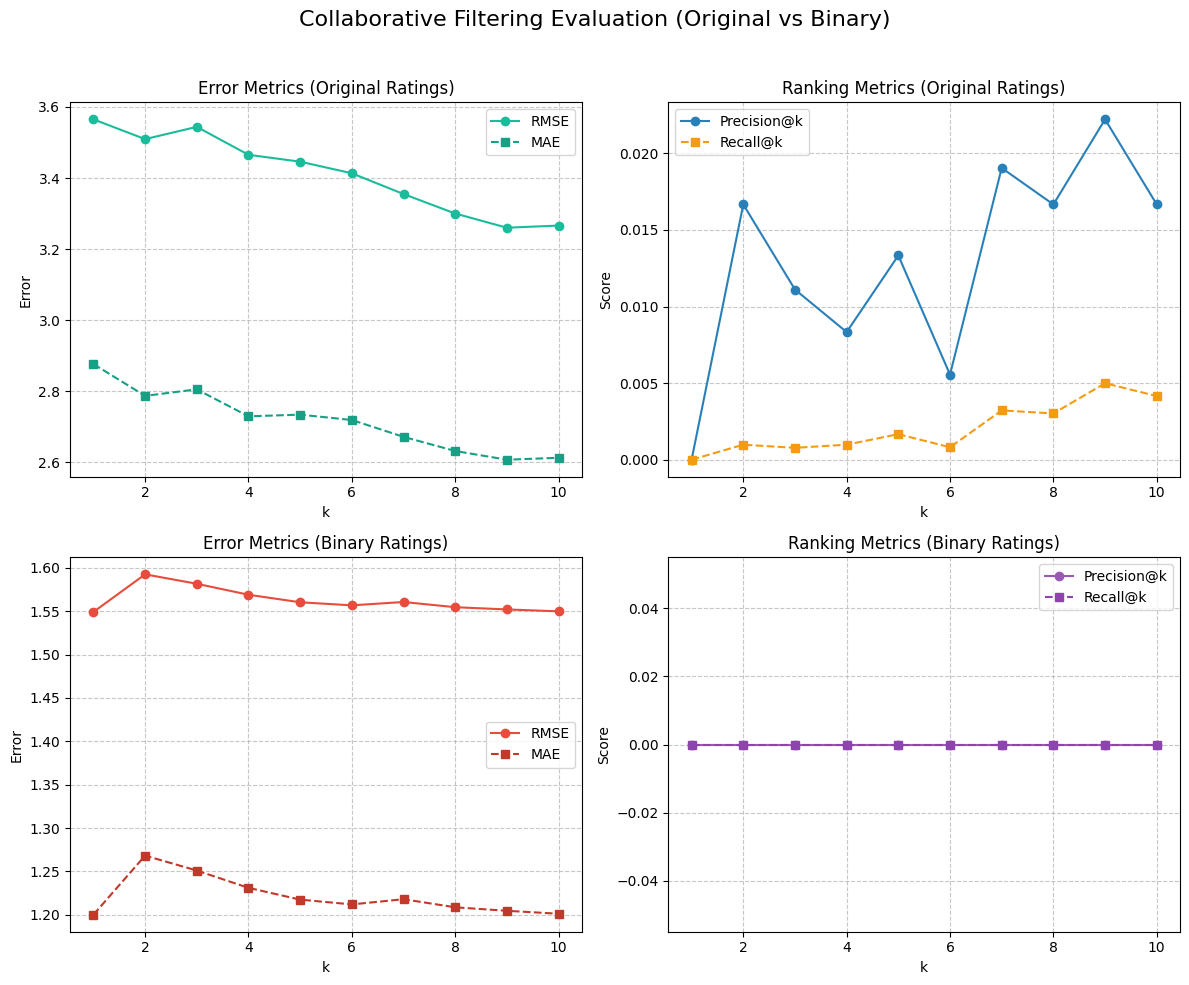

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Collaborative Filtering Evaluation (Original vs Binary)', fontsize=16)

# Top-left: Error metrics (Original)
axs[0, 0].plot(k_values, rmse_orig_cf, label='RMSE', marker='o', color='#1abc9c')
axs[0, 0].plot(k_values, mae_orig_cf, label='MAE', marker='s', linestyle='--', color='#16a085')
axs[0, 0].set_title('Error Metrics (Original Ratings)')
axs[0, 0].set_xlabel('k')
axs[0, 0].set_ylabel('Error')
axs[0, 0].legend()
axs[0, 0].grid(True, linestyle='--', alpha=0.7)

# Top-right: Ranking metrics (Original)
axs[0, 1].plot(k_values, precision_orig_cf, label='Precision@k', marker='o', color='#2980b9')
axs[0, 1].plot(k_values, recall_orig_cf, label='Recall@k', marker='s', linestyle='--', color='#f39c12')
axs[0, 1].set_title('Ranking Metrics (Original Ratings)')
axs[0, 1].set_xlabel('k')
axs[0, 1].set_ylabel('Score')
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.7)

# Bottom-left: Error metrics (Binary)
axs[1, 0].plot(k_values, rmse_bin_cf, label='RMSE', marker='o', color='#e74c3c')
axs[1, 0].plot(k_values, mae_bin_cf, label='MAE', marker='s', linestyle='--', color='#c0392b')
axs[1, 0].set_title('Error Metrics (Binary Ratings)')
axs[1, 0].set_xlabel('k')
axs[1, 0].set_ylabel('Error')
axs[1, 0].legend()
axs[1, 0].grid(True, linestyle='--', alpha=0.7)

# Bottom-right: Ranking metrics (Binary)
axs[1, 1].plot(k_values, precision_bin_cf, label='Precision@k', marker='o', color='#9b59b6')
axs[1, 1].plot(k_values, recall_bin_cf, label='Recall@k', marker='s', linestyle='--', color='#8e44ad')
axs[1, 1].set_title('Ranking Metrics (Binary Ratings)')
axs[1, 1].set_xlabel('k')
axs[1, 1].set_ylabel('Score')
axs[1, 1].legend()
axs[1, 1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Two Towers

In [16]:
class TwoTowerModel(nn.Module):
    def __init__(self, embedding_dim=512, hidden_dim=64):
        super(TwoTowerModel, self).__init__()

        # Projection layers to transform original embeddings
        self.user_tower = nn.Sequential(
            nn.Linear(2519, 128),
            nn.ReLU()
        )
        self.item_tower = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU()
        )

        # Map similarity score to rating
        self.rating_predictor = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, 1)
        )

    def forward(self, user_emb, item_emb):
        # Get embeddings from towers
        user_repr = self.user_tower(user_emb)
        item_repr = self.item_tower(item_emb)

        # Compute cosine similarity
        user_repr = F.normalize(user_repr, p=2, dim=1)
        item_repr = F.normalize(item_repr, p=2, dim=1)
        similarity = torch.sum(user_repr * item_repr, dim=1, keepdim=True)

        rating = self.rating_predictor(similarity)
        return rating.squeeze(-1)

In [17]:
true_item_dim = len(embeddings_df['combined_embedding'][0])
model = TwoTowerModel(embedding_dim=true_item_dim)

train_data_tensors, val_data_tensors = prepare_two_tower_data(train_data, val_data, embeddings_df, users_embeddings_df)
train_losses, val_losses = train_two_tower_model(model, train_data_tensors, val_data_tensors)
rmse, mae, precision, recall = evaluate_two_tower_model(model, val_data_tensors, val_data, embeddings_df, users_embeddings_df)

print(f"Two-Tower Model Results:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Precision@10: {precision:.4f}")
print(f"Recall@10: {recall:.4f}")

/Users/vivxi/Desktop/STAT_4830/STAT-4830-vllm-project/src/utils/two_towers.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  user_embeddings = torch.tensor(user_embeddings_df['combined_embeddings'].tolist()).float()


Epoch 1/10:
Training Loss: 9.1296
Validation Loss: 6.1708
Epoch 2/10:
Training Loss: 6.1243
Validation Loss: 6.1896
Epoch 3/10:
Training Loss: 6.0228
Validation Loss: 6.3080
Epoch 4/10:
Training Loss: 5.8716
Validation Loss: 6.5131
Epoch 5/10:
Training Loss: 5.6453
Validation Loss: 6.7607
Epoch 6/10:
Training Loss: 5.3686
Validation Loss: 7.0516
Epoch 7/10:
Training Loss: 5.0462
Validation Loss: 7.3273
Epoch 8/10:
Training Loss: 4.7227
Validation Loss: 7.6696
Epoch 9/10:
Training Loss: 4.3927
Validation Loss: 8.0066
Epoch 10/10:
Training Loss: 4.0569
Validation Loss: 8.2714
Two-Tower Model Results:
RMSE: 2.8760
MAE: 2.3182
Precision@10: 0.0133
Recall@10: 0.0030


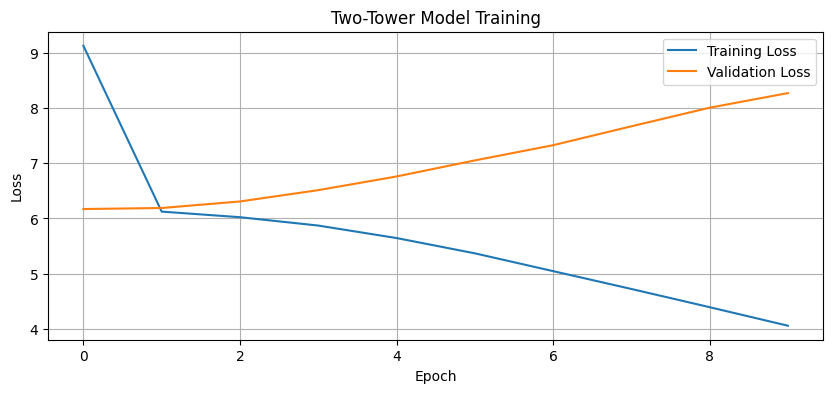

In [18]:
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Two-Tower Model Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# rebuild binary user embeddings DataFrame
user_item_bin = np.zeros((n_users, n_items), dtype=int)
for img_id in range(n_items):
    for usr_id in range(n_users):
        user_item_bin[usr_id, img_id] = binary_ratings.iat[img_id, usr_id]

users_embeddings_bin_df = pd.DataFrame({
    "combined_embeddings": [user_item_bin[u] for u in range(n_users)]
})

train_tensors_bin, val_tensors_bin = prepare_two_tower_data(
    train_data_bin, val_data_bin,
    item_embeddings_df=embeddings_df,
    user_embeddings_df=users_embeddings_bin_df
)

model_bin = TwoTowerModel(embedding_dim=true_item_dim)
train_losses_bin, val_losses_bin = train_two_tower_model(
    model_bin, train_tensors_bin, val_tensors_bin,
    num_epochs=10, batch_size=32
)

rmse_tt, mae_tt, prec_tt, rec_tt = evaluate_two_tower_model(
    model_bin, val_tensors_bin, val_data_bin,
    embeddings_df, users_embeddings_bin_df
)
print("Two-Tower Model on binary data:")
print(f"  RMSE:      {rmse_tt:.4f}")
print(f"  MAE:       {mae_tt:.4f}")
print(f"  Precision: {prec_tt:.4f}")
print(f"  Recall:    {rec_tt:.4f}")

Epoch 1/10:
Training Loss: 0.9673
Validation Loss: 0.9559
Epoch 2/10:
Training Loss: 0.9588
Validation Loss: 0.9563
Epoch 3/10:
Training Loss: 0.9448
Validation Loss: 0.9644
Epoch 4/10:
Training Loss: 0.9134
Validation Loss: 0.9882
Epoch 5/10:
Training Loss: 0.8608
Validation Loss: 1.0317
Epoch 6/10:
Training Loss: 0.8081
Validation Loss: 1.0663
Epoch 7/10:
Training Loss: 0.7590
Validation Loss: 1.0974
Epoch 8/10:
Training Loss: 0.7092
Validation Loss: 1.1353
Epoch 9/10:
Training Loss: 0.6641
Validation Loss: 1.1859
Epoch 10/10:
Training Loss: 0.6310
Validation Loss: 1.2179
Two-Tower Model on binary data:
  RMSE:      1.1036
  MAE:       0.9456
  Precision: 0.0000
  Recall:    0.0000


In [20]:
# Original model results
# train_losses, val_losses = train_two_tower_model(model, train_data_tensors, val_data_tensors)
rmse_tt_orig, mae_tt_orig, prec_tt_orig, rec_tt_orig = evaluate_two_tower_model(
    model, val_data_tensors, val_data, embeddings_df, users_embeddings_df)

# Binary model results
# train_losses_bin, val_losses_bin = train_two_tower_model(model_bin, train_tensors_bin, val_tensors_bin)
rmse_tt_bin, mae_tt_bin, prec_tt_bin, rec_tt_bin = evaluate_two_tower_model(
    model_bin, val_tensors_bin, val_data_bin, embeddings_df, users_embeddings_bin_df)

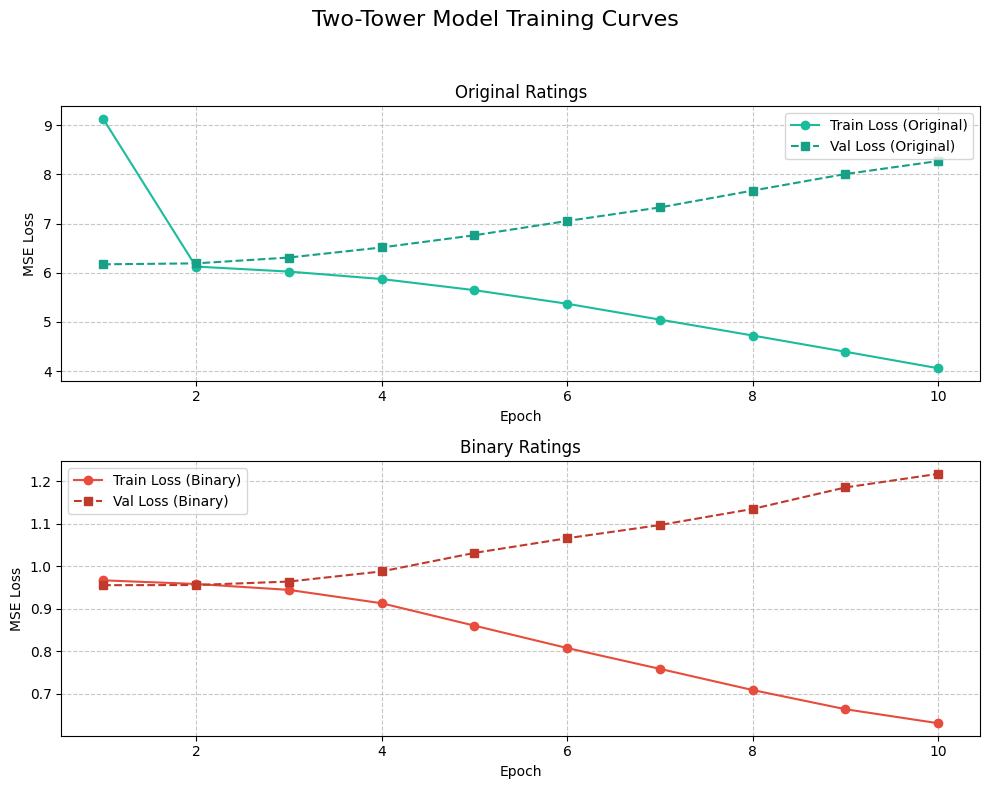

In [21]:
# === Loss Curve Visualization ===
epochs = list(range(1, len(train_losses)+1))

fig, axs = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle("Two-Tower Model Training Curves", fontsize=16)

# Top: Original ratings
axs[0].plot(epochs, train_losses, label='Train Loss (Original)', marker='o', color='#1abc9c')
axs[0].plot(epochs, val_losses, label='Val Loss (Original)', marker='s', linestyle='--', color='#16a085')
axs[0].set_title('Original Ratings')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('MSE Loss')
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.7)

# Bottom: Binary ratings
axs[1].plot(epochs, train_losses_bin, label='Train Loss (Binary)', marker='o', color='#e74c3c')
axs[1].plot(epochs, val_losses_bin, label='Val Loss (Binary)', marker='s', linestyle='--', color='#c0392b')
axs[1].set_title('Binary Ratings')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MSE Loss')
axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

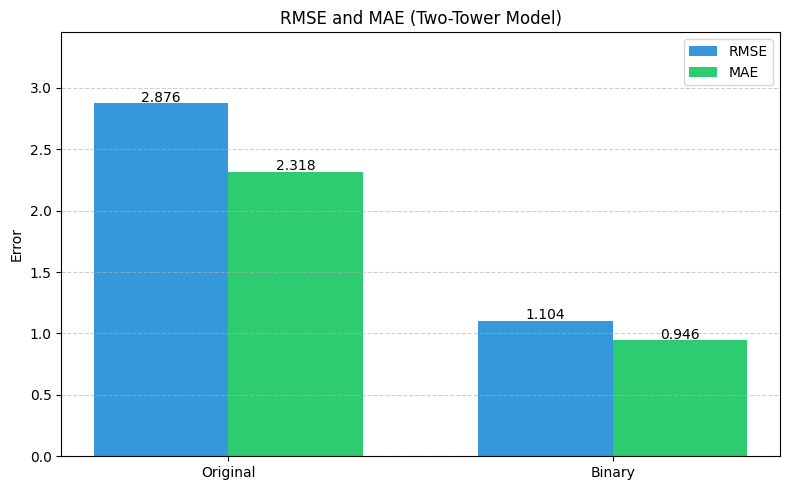

In [22]:
# RMSE bar chart
rmse_vals = [rmse_tt_orig, rmse_tt_bin]
mae_vals  = [mae_tt_orig, mae_tt_bin]

labels = ['Original', 'Binary']
x = np.arange(len(labels))
width = 0.35

# Create RMSE + MAE bar plot
plt.figure(figsize=(8, 5))
plt.bar(x - width/2, rmse_vals, width, label='RMSE', color='#3498db')
plt.bar(x + width/2, mae_vals,  width, label='MAE',  color='#2ecc71')

# Format
plt.xticks(x, labels)
plt.ylabel('Error')
plt.title('RMSE and MAE (Two-Tower Model)')
plt.ylim(0, max(rmse_vals + mae_vals) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()

# Annotate values
for i in range(len(labels)):
    plt.text(i - width/2, rmse_vals[i] + 0.01, f"{rmse_vals[i]:.3f}", ha='center', fontsize=10)
    plt.text(i + width/2, mae_vals[i] + 0.01,  f"{mae_vals[i]:.3f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

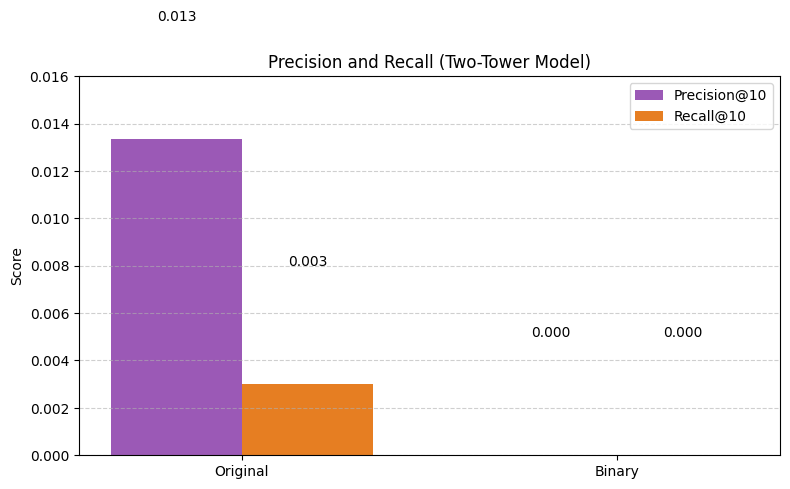

In [23]:
# Precision bar chart
prec_vals = [prec_tt_orig, prec_tt_bin]
rec_vals  = [rec_tt_orig, rec_tt_bin]

# Create Precision + Recall bar plot
plt.figure(figsize=(8, 5))
plt.bar(x - width/2, prec_vals, width, label='Precision@10', color='#9b59b6')
plt.bar(x + width/2, rec_vals,  width, label='Recall@10',    color='#e67e22')

# Format
plt.xticks(x, labels)
plt.ylabel('Score')
plt.title('Precision and Recall (Two-Tower Model)')
plt.ylim(0, max(prec_vals + rec_vals) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()

# Annotate values
for i in range(len(labels)):
    plt.text(i - width/2, prec_vals[i] + 0.005, f"{prec_vals[i]:.3f}", ha='center', fontsize=10)
    plt.text(i + width/2, rec_vals[i]  + 0.005, f"{rec_vals[i]:.3f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Content Filtering

In [24]:
## Cosine similarity for the items
def compute_user_similarity(embeddings):
    similarity = cosine_similarity(embeddings)
    np.fill_diagonal(similarity, 0)
    return similarity

## Fills the sparse matrix with the predicted values
def predict_item_content_filtering(ratings_matrix, similarity_matrix, k=10):
    n_users, n_items = ratings_matrix.shape
    ratings_array = ratings_matrix.toarray()
    predicted_ratings = np.zeros((n_users, n_items))

    for item_idx in range(n_items):
        # Get top-k similar users
        item_similarities = similarity_matrix[item_idx]
        top_k_items = np.argsort(item_similarities)[::-1][:k]

        for user_idx in range(n_users):
            if ratings_array[user_idx, item_idx] > 0: ## User has already rated this item
                predicted_ratings[user_idx, item_idx] = ratings_array[user_idx, item_idx]
                continue

            sim_users_ratings = ratings_array[user_idx, top_k_items]
            sim_users_sims = item_similarities[top_k_items]

            # Filter out users who haven't rated this item
            mask = sim_users_ratings > 0
            sim_users_ratings = sim_users_ratings[mask]
            sim_users_sims = sim_users_sims[mask]

            if len(sim_users_ratings) > 0:
                predicted_ratings[user_idx, item_idx] = np.sum(sim_users_ratings * sim_users_sims) / (np.sum(sim_users_sims) + 1e-10)

    return predicted_ratings

def precision_recall_at_k(predictions, k=10, threshold=7):
    n_users = predictions.shape[0]
    precision_scores = []
    recall_scores = []

    for user_idx in range(n_users):
        relevant_items = set()
        for image_id, user_id, rating in val_data:
            if user_id == user_idx and rating >= threshold:
                relevant_items.add(image_id)

        # Skip users with no relevant items
        if not relevant_items:
            continue

        # Get top-k recommendations
        user_ratings = predictions[user_idx]
        for image_id, user_id, rating in train_data:
            if user_id == user_idx:
                user_ratings[image_id] = -1
        top_k_items = np.argsort(user_ratings)[::-1][:k]
        top_k_items = set(top_k_items)

        # Calculate metrics
        n_rel_and_rec = len(relevant_items.intersection(top_k_items))

        precision = n_rel_and_rec / k if k != 0 else 0
        recall = n_rel_and_rec / len(relevant_items) if len(relevant_items) != 0 else 0

        precision_scores.append(precision)
        recall_scores.append(recall)

    avg_precision = np.mean(precision_scores) if precision_scores else 0
    avg_recall = np.mean(recall_scores) if recall_scores else 0

    return avg_precision, avg_recall


def evaluate_content_filtering(train_data, val_data, embeddings_df, n_users, n_items, k=10):
    ## Create training matrix
    train_matrix = np.zeros((n_items, n_users))
    for image_id, user_id, rating in train_data:
        train_matrix[image_id, user_id] = rating

    train_matrix_sparse = csr_matrix(train_matrix)

    ## Compute user similarity matrix and perform prediction
    embedding_array = np.array(embeddings_df['combined_embedding'].tolist())
    similarity_matrix = compute_user_similarity(embeddings=embedding_array)
    predictions = predict_item_content_filtering(train_matrix_sparse.T, similarity_matrix, k=k) ## Fill the sparse matrix with the predicted values

    ## Recall and precision @ k
    precision, recall = precision_recall_at_k(predictions, k=k, threshold=7)

    ## Calculate the error
    val_predictions = []
    val_true_ratings = []

    for image_id, user_id, rating in val_data:
        predicted = predictions[user_id, image_id]
        if predicted > 0:
            val_predictions.append(predicted)
            val_true_ratings.append(rating)

    rmse = math.sqrt(mean_squared_error(val_true_ratings, val_predictions))
    mae = np.mean(np.abs(np.array(val_predictions) - np.array(val_true_ratings)))
    return rmse, mae, precision, recall

In [25]:
n_items, n_users = ratings_df.shape

rmse_orig_cbf, mae_orig_cbf, precision_orig_cbf, recall_orig_cbf = evaluate_content_filtering(
    train_data, val_data, embeddings_df, n_users, n_items
)
print(f"RMSE: {rmse_orig_cbf:.4f}")
print(f"MAE: {mae_orig_cbf:.4f}")
print(f"Precision: {precision_orig_cbf:.4f}")
print(f"Recall: {recall_orig_cbf:.4f}")

RMSE: 3.1623
MAE: 2.5098
Precision: 0.0367
Recall: 0.0089


In [26]:
# Binary
rmse_bin_cbf, mae_bin_cbf, precision_bin_cbf, recall_bin_cbf = evaluate_content_filtering(
    train_data_bin, val_data_bin, embeddings_df, n_users, n_items
)
print(f"Content-Based Filtering on binary data:")
print(f"  RMSE:      {rmse_bin_cbf:.4f}")
print(f"  MAE:       {mae_bin_cbf:.4f}")
print(f"  Precision: {precision_bin_cbf:.4f}")
print(f"  Recall:    {recall_bin_cbf:.4f}\n")

Content-Based Filtering on binary data:
  RMSE:      1.5473
  MAE:       1.1971
  Precision: 1.0000
  Recall:    0.2510



In [27]:
k_values = list(range(1, 11))

# Results containers
rmse_orig_cbf, mae_orig_cbf = [], []
prec_orig_cbf, rec_orig_cbf = [], []

rmse_bin_cbf, mae_bin_cbf = [], []
prec_bin_cbf, rec_bin_cbf = [], []

for k in k_values:
    # Original
    r, m, p, rc = evaluate_content_filtering(train_data, val_data, embeddings_df, n_users, n_items, k)
    rmse_orig_cbf.append(r)
    mae_orig_cbf.append(m)
    prec_orig_cbf.append(p)
    rec_orig_cbf.append(rc)

    # Binary
    r_bin, m_bin, p_bin, rc_bin = evaluate_content_filtering(train_data_bin, val_data_bin, embeddings_df, n_users, n_items, k)
    rmse_bin_cbf.append(r_bin)
    mae_bin_cbf.append(m_bin)
    prec_bin_cbf.append(p_bin)
    rec_bin_cbf.append(rc_bin)


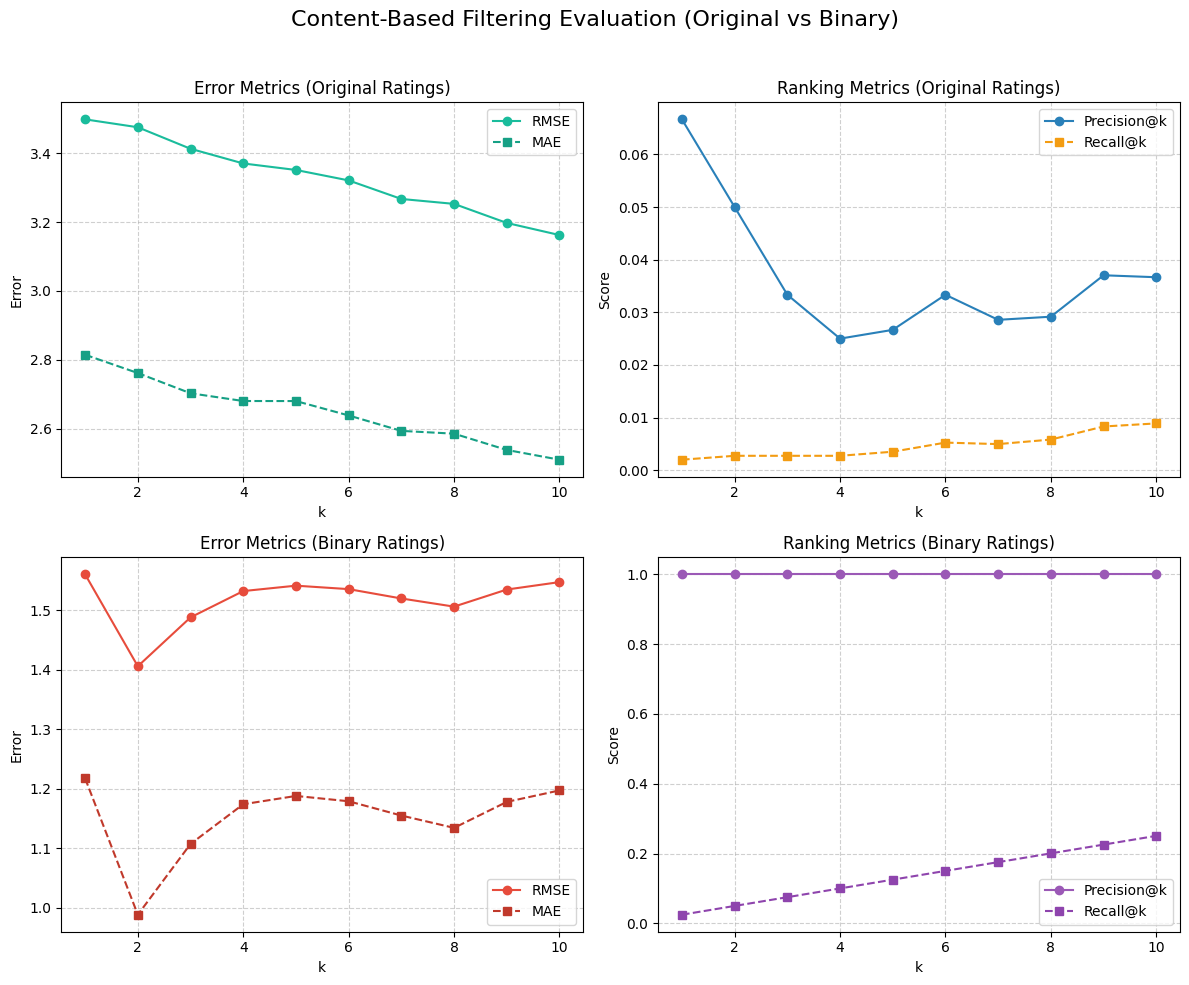

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Content-Based Filtering Evaluation (Original vs Binary)', fontsize=16)

# ---- Top-Left: RMSE & MAE (Original)
axs[0, 0].plot(k_values, rmse_orig_cbf, label='RMSE', marker='o', color='#1abc9c')
axs[0, 0].plot(k_values, mae_orig_cbf, label='MAE', marker='s', linestyle='--', color='#16a085')
axs[0, 0].set_title('Error Metrics (Original Ratings)')
axs[0, 0].set_xlabel('k')
axs[0, 0].set_ylabel('Error')
axs[0, 0].legend()
axs[0, 0].grid(True, linestyle='--', alpha=0.6)

# ---- Top-Right: Precision & Recall (Original)
axs[0, 1].plot(k_values, prec_orig_cbf, label='Precision@k', marker='o', color='#2980b9')
axs[0, 1].plot(k_values, rec_orig_cbf, label='Recall@k', marker='s', linestyle='--', color='#f39c12')
axs[0, 1].set_title('Ranking Metrics (Original Ratings)')
axs[0, 1].set_xlabel('k')
axs[0, 1].set_ylabel('Score')
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.6)

# ---- Bottom-Left: RMSE & MAE (Binary)
axs[1, 0].plot(k_values, rmse_bin_cbf, label='RMSE', marker='o', color='#e74c3c')
axs[1, 0].plot(k_values, mae_bin_cbf, label='MAE', marker='s', linestyle='--', color='#c0392b')
axs[1, 0].set_title('Error Metrics (Binary Ratings)')
axs[1, 0].set_xlabel('k')
axs[1, 0].set_ylabel('Error')
axs[1, 0].legend()
axs[1, 0].grid(True, linestyle='--', alpha=0.6)

# ---- Bottom-Right: Precision & Recall (Binary)
axs[1, 1].plot(k_values, prec_bin_cbf, label='Precision@k', marker='o', color='#9b59b6')
axs[1, 1].plot(k_values, rec_bin_cbf, label='Recall@k', marker='s', linestyle='--', color='#8e44ad')
axs[1, 1].set_title('Ranking Metrics (Binary Ratings)')
axs[1, 1].set_xlabel('k')
axs[1, 1].set_ylabel('Score')
axs[1, 1].legend()
axs[1, 1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Low Rank Matrix Completion

### Classic Low Rank

implementation of a classic low-rank matrix factorization model (without item embeddings), where we optimize two learnable matrices:
$U \in \mathbb{R}^{n_{users} \times r}$ and $V \in \mathbb{R}^{n_{items} \times r}$ 
to approximate the observed sparse rating matrix $R = UV^T$.

In [29]:
class ClassicLowRank(nn.Module):
    def __init__(self, num_users, num_items, rank):
        super().__init__()
        self.U = nn.Embedding(num_users, rank)
        self.V = nn.Embedding(num_items, rank)
        nn.init.normal_(self.U.weight, std=0.1)
        nn.init.normal_(self.V.weight, std=0.1)

    def forward(self, user_ids, item_ids):
        u = self.U(user_ids)
        v = self.V(item_ids)
        preds = torch.sum(u * v, dim=1)
        return preds

In [30]:
def train_classic_low_rank(model, train_data, val_data, num_epochs=50, lr=0.01, batch_size=512, verbose=True):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        random.shuffle(train_data)

        for i in range(0, len(train_data), batch_size):
            batch = train_data[i:i+batch_size]
            user_ids, item_ids, ratings = zip(*batch)
            user_ids = torch.tensor(user_ids).long()
            item_ids = torch.tensor(item_ids).long()
            ratings = torch.tensor(ratings).float()

            preds = model(user_ids, item_ids)
            loss = loss_fn(preds, ratings)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / (len(train_data) / batch_size)
        train_losses.append(avg_train_loss)

        # Validation loss
        model.eval()
        with torch.no_grad():
            u_val, i_val, r_val = zip(*val_data)
            u_val = torch.tensor(u_val).long()
            i_val = torch.tensor(i_val).long()
            r_val = torch.tensor(r_val).float()
            val_preds = model(u_val, i_val)
            val_loss = loss_fn(val_preds, r_val)
            val_losses.append(val_loss.item())

        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {avg_train_loss:.4f} — Val Loss: {val_loss.item():.4f}")

    return train_losses, val_losses

In [31]:
def evaluate_classic_low_rank(model, val_data, threshold=7, k=10):
    model.eval()
    with torch.no_grad():
        u_ids, i_ids, ratings = zip(*val_data)
        u_tensor = torch.tensor(u_ids).long()
        i_tensor = torch.tensor(i_ids).long()
        r_tensor = torch.tensor(ratings).float()
        preds = model(u_tensor, i_tensor)

    rmse = np.sqrt(mean_squared_error(r_tensor.numpy(), preds.numpy()))
    mae = np.mean(np.abs(r_tensor.numpy() - preds.numpy()))
    return rmse, mae

In [32]:
from collections import defaultdict
def precision_recall_at_k_classic(model, train_data, val_data, num_users, num_items, k=10, threshold=7):
    model.eval()

    # Build fast access dicts
    train_seen = defaultdict(set)
    val_relevant = defaultdict(set)

    for u, i, r in train_data:
        train_seen[u].add(i)
    for u, i, r in val_data:
        if r >= threshold:
            val_relevant[u].add(i)

    precs, recs = [], []

    with torch.no_grad():
        for u in range(num_users):
            if len(val_relevant[u]) == 0:
                continue

            # Predict scores for all items for user u
            u_tensor = torch.tensor([u] * num_items).long()
            i_tensor = torch.arange(num_items).long()
            scores = model(u_tensor, i_tensor).numpy()

            # Mask out training items
            for i in train_seen[u]:
                scores[i] = -np.inf

            top_k_items = np.argsort(scores)[-k:][::-1]
            top_k_set = set(top_k_items)

            hits = len(top_k_set & val_relevant[u])
            precs.append(hits / k)
            recs.append(hits / len(val_relevant[u]))

    avg_prec = np.mean(precs) if precs else 0
    avg_rec = np.mean(recs) if recs else 0
    return avg_prec, avg_rec

In [33]:
n_items, n_users = ratings_df.shape  # Transpose shape if needed

# Flip shape to match torch (users first U matrix)
train_data_flipped = [(user, item, rating) for item, user, rating in train_data]
val_data_flipped = [(user, item, rating) for item, user, rating in val_data]

In [34]:
ranks = list(range(2, 31))

rmse_list = []
mae_list = []
precision_list = []
recall_list = []

for rank in ranks:
    model = ClassicLowRank(num_users=n_users, num_items=n_items, rank=rank)

    train_losses, val_losses = train_classic_low_rank(
        model, train_data_flipped, val_data_flipped,
        num_epochs=30, lr=0.01, batch_size=512, verbose=False
    )

    rmse, mae = evaluate_classic_low_rank(model, val_data_flipped)
    precision, recall = precision_recall_at_k_classic(
        model, train_data_flipped, val_data_flipped,
        num_users=n_users, num_items=n_items,
        k=10, threshold=7
    )

    rmse_list.append(rmse)
    mae_list.append(mae)
    precision_list.append(precision)
    recall_list.append(recall)

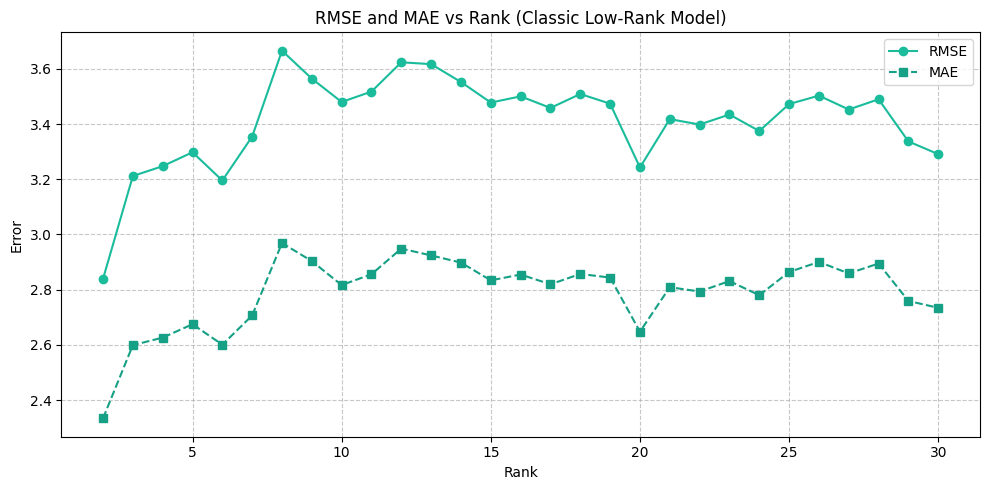

In [35]:
# RMSE and MAE vs Rank
plt.figure(figsize=(10, 5))
plt.plot(ranks, rmse_list, label='RMSE', marker='o', color='#1abc9c')
plt.plot(ranks, mae_list, label='MAE', marker='s', linestyle='--', color='#16a085')
plt.xlabel("Rank")
plt.ylabel("Error")
plt.title("RMSE and MAE vs Rank (Classic Low-Rank Model)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

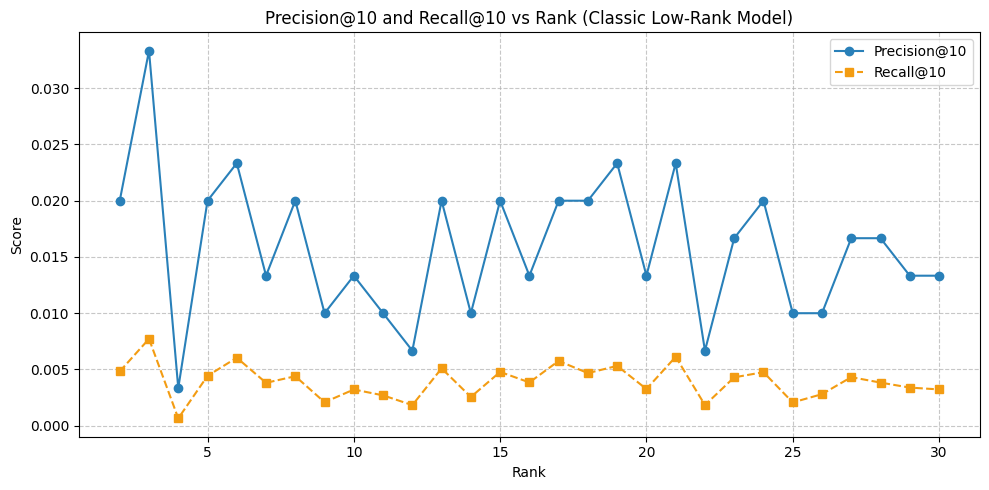

In [36]:
# Precision and Recall vs Rank
plt.figure(figsize=(10, 5))
plt.plot(ranks, precision_list, label='Precision@10', marker='o', color='#2980b9')
plt.plot(ranks, recall_list, label='Recall@10', marker='s', linestyle='--', color='#f39c12')
plt.xlabel("Rank")
plt.ylabel("Score")
plt.title("Precision@10 and Recall@10 vs Rank (Classic Low-Rank Model)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [37]:
best_index = np.argmax(precision_list)
best_rank = ranks[best_index]

print(f"Best Precision@10 achieved at rank = {best_rank}")
print(f"RMSE:        {rmse_list[best_index]:.4f}")
print(f"MAE:         {mae_list[best_index]:.4f}")
print(f"Precision@10:{precision_list[best_index]:.4f}")
print(f"Recall@10:   {recall_list[best_index]:.4f}")

Best Precision@10 achieved at rank = 3
RMSE:        3.2117
MAE:         2.5994
Precision@10:0.0333
Recall@10:   0.0077


### Binary

In [38]:
train_data_bin_flipped = [(user, item, rating) for item, user, rating in train_data_bin]
val_data_bin_flipped   = [(user, item, rating) for item, user, rating in val_data_bin]

In [39]:
ranks = list(range(2, 31))
rmse_bin_list, mae_bin_list = [], []
precision_bin_list, recall_bin_list = [], []

for rank in ranks:
    model_bin = ClassicLowRank(num_users=n_users, num_items=n_items, rank=rank)

    _ = train_classic_low_rank(
        model_bin, train_data_bin_flipped, val_data_bin_flipped,
        num_epochs=30, lr=0.01, batch_size=512, verbose=False
    )

    rmse, mae = evaluate_classic_low_rank(model_bin, val_data_bin_flipped)
    prec, rec = precision_recall_at_k_classic(
        model_bin, train_data_bin_flipped, val_data_bin_flipped,
        num_users=n_users, num_items=n_items, k=10, threshold=1
    )

    rmse_bin_list.append(rmse)
    mae_bin_list.append(mae)
    precision_bin_list.append(prec)
    recall_bin_list.append(rec)

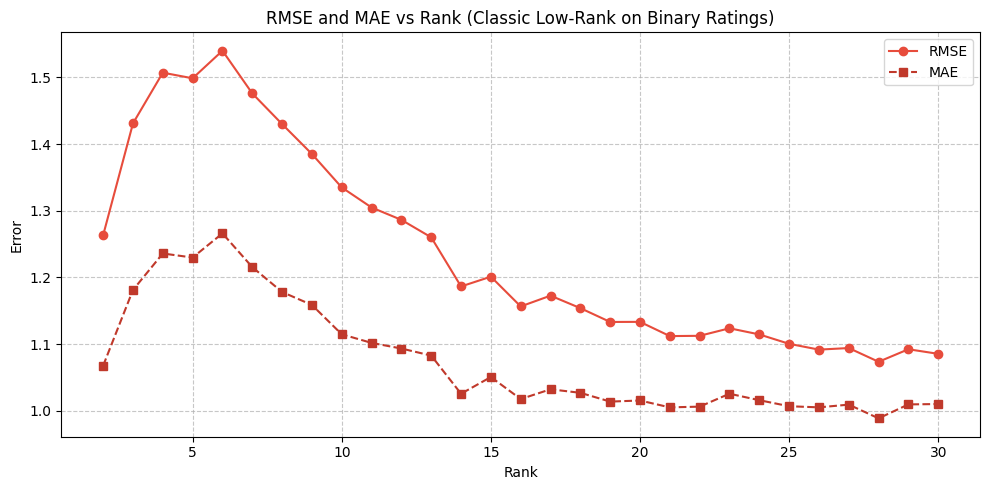

In [40]:
# RMSE and MAE vs Rank (Binary)
plt.figure(figsize=(10, 5))
plt.plot(ranks, rmse_bin_list, label='RMSE', marker='o', color='#e74c3c')
plt.plot(ranks, mae_bin_list, label='MAE', marker='s', linestyle='--', color='#c0392b')
plt.xlabel("Rank")
plt.ylabel("Error")
plt.title("RMSE and MAE vs Rank (Classic Low-Rank on Binary Ratings)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

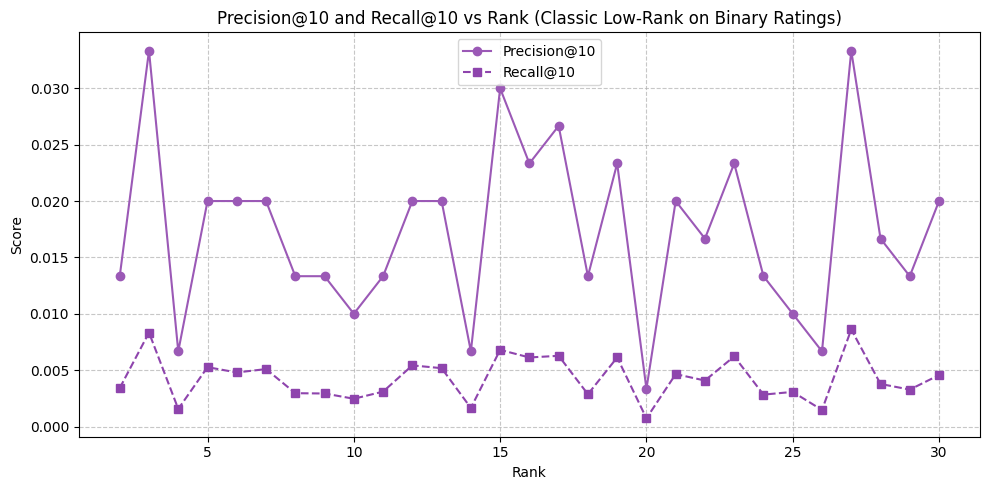

In [41]:
# Precision and Recall vs Rank (Binary)
plt.figure(figsize=(10, 5))
plt.plot(ranks, precision_bin_list, label='Precision@10', marker='o', color='#9b59b6')
plt.plot(ranks, recall_bin_list, label='Recall@10', marker='s', linestyle='--', color='#8e44ad')
plt.xlabel("Rank")
plt.ylabel("Score")
plt.title("Precision@10 and Recall@10 vs Rank (Classic Low-Rank on Binary Ratings)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [42]:
# Get top 3 indices sorted by descending precision
top_k = 3
top_indices = np.argsort(precision_bin_list)[-top_k:][::-1]

print(f"Top {top_k} Classic Low-Rank Results (Binary Ratings) by Precision@10:\n")
for idx in top_indices:
    print(f"Rank {ranks[idx]}:")
    print(f"Precision@10: {precision_bin_list[idx]:.4f}")
    print(f"Recall@10:    {recall_bin_list[idx]:.4f}")
    print(f"RMSE:         {rmse_bin_list[idx]:.4f}")
    print(f"MAE:          {mae_bin_list[idx]:.4f}")
    print()

Top 3 Classic Low-Rank Results (Binary Ratings) by Precision@10:

Rank 27:
Precision@10: 0.0333
Recall@10:    0.0086
RMSE:         1.0942
MAE:          1.0094

Rank 3:
Precision@10: 0.0333
Recall@10:    0.0083
RMSE:         1.4309
MAE:          1.1813

Rank 15:
Precision@10: 0.0300
Recall@10:    0.0068
RMSE:         1.2012
MAE:          1.0508



### Fixed Projection Layer with Item Embeddings

In [43]:
# Create a single 2D feature matrix
features = np.stack(embeddings_df['combined_embedding'].values)  # shape: [n_items, embedding_dim]
feature_dim = features.shape[1]  # number of features per item
# Normalize item embeddings to unit scale
# features = (features - features.mean(axis=0)) / (features.std(axis=0) + 1e-8)


# Create train_mask and val_mask
n_items = max([x[0] for x in train_data + val_data]) + 1
n_users = max([x[1] for x in train_data + val_data]) + 1

train_mask = np.zeros((n_items, n_users), dtype=bool)
val_mask = np.zeros((n_items, n_users), dtype=bool)

for i, j, _ in train_data:
    train_mask[i, j] = True

for i, j, _ in val_data:
    val_mask[i, j] = True


# Create fixed projection layer
def create_fixed_projection(feature_dim, rank):
    torch.manual_seed(SEED)
    proj = torch.nn.Linear(feature_dim, rank).to(device)
    torch.nn.init.xavier_uniform_(proj.weight)
    proj.bias.data.fill_(0)
    return proj

In [44]:
def precision_recall_at_k_lowrank(predictions, train_data, val_data, k=10, threshold=7):
    from collections import defaultdict

    # build sets of seen items per user
    train_rated = defaultdict(set)
    for i, u, _ in train_data:
        train_rated[u].add(i)

    # build sets of relevant items per user
    val_relevant = defaultdict(set)
    for i, u, r in val_data:
        if r >= threshold:
            val_relevant[u].add(i)

    precisions, recalls = [], []
    for u, relevant in val_relevant.items():
        # copy this user's predictions and mask out seen items
        user_preds = predictions[:, u].copy()
        seen = train_rated.get(u, set())
        if seen:
            user_preds[list(seen)] = -np.inf

        # top-k indices
        top_k = np.argsort(user_preds)[::-1][:k]
        hits = len(set(top_k) & relevant)

        precisions.append(hits / k)
        recalls.append(hits / len(relevant))

    if not precisions:
        return 0.0, 0.0

    return np.mean(precisions), np.mean(recalls)

In [45]:
def evaluate_low_rank_with_projection(features, ratings_df, projection, train_mask, val_mask, rank,
                                      num_epochs=500, lr=0.001, lambda_reg=0.05, threshold=7):
    n_items, n_users = ratings_df.shape
    M_tensor = torch.tensor(ratings_df.values, dtype=torch.float32, device=device)

    # Fixed item embeddings from projection layer
    with torch.no_grad():
        U = projection(torch.tensor(features, dtype=torch.float32, device=device))
        print("Mean L2 norm of projected U vectors:", np.linalg.norm(U.cpu().numpy(), axis=1).mean())
    U.requires_grad = False

    torch.manual_seed(SEED)
    V = torch.nn.Parameter(torch.randn(n_users, rank, device=device))
    optimizer = torch.optim.Adam([V], lr=lr)

    for epoch in range(num_epochs):
        pred = U @ V.T
        diff_train = (pred - M_tensor)[train_mask]
        loss = torch.mean(diff_train ** 2) + lambda_reg * torch.norm(V)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

    print("Final V norm:", V.norm().item())
    # Evaluate
    pred_matrix = (U @ V.T).detach().cpu().numpy()

    # rebuild validation list
    val_list = [
        (i, j, ratings_df.iat[i, j])
        for i in range(n_items)
        for j in range(n_users)
        if val_mask[i, j]
    ]

    # RMSE & MAE
    ys_true = np.array([r for (_, _, r) in val_list])
    ys_pred = np.array([pred_matrix[i, j] for (i, j, _) in val_list])
    rmse = np.sqrt(mean_squared_error(ys_true, ys_pred))
    mae  = np.mean(np.abs(ys_pred - ys_true))

    # precision & recall @ k
    prec, rec = precision_recall_at_k_lowrank(
        pred_matrix, train_data, val_list,
        k=k, threshold=threshold
    )

    return rmse, mae, precision, recall, pred_matrix


In [46]:
from collections import defaultdict
import random

def inspect_lowrank_topk_debug(predictions, train_data, val_data, k=10, threshold=7, n_users_to_print=5):
    # Build seen items and relevant items per user
    train_rated = defaultdict(set)
    val_relevant = defaultdict(set)

    for i, u, _ in train_data:
        train_rated[u].add(i)

    for i, u, r in val_data:
        if r >= threshold:
            val_relevant[u].add(i)

    users_to_check = random.sample(list(val_relevant.keys()), min(n_users_to_print, len(val_relevant)))

    print(f"\nInspecting Top-{k} predictions for {len(users_to_check)} users:\n")
    for u in users_to_check:
        user_preds = predictions[:, u].copy()
        seen = train_rated.get(u, set())
        if seen:
            user_preds[list(seen)] = -np.inf  # mask seen

        top_k = np.argsort(user_preds)[::-1][:k]
        relevant = val_relevant[u]

        print(f"User {u}")
        print(f"  Relevant items (validation): {sorted(relevant)}")
        print(f"  Seen items (training):       {sorted(seen)}")
        print(f"  Top-{k} predictions:         {sorted(top_k)}")
        hits = set(top_k) & relevant
        print(f"  Hits in Top-{k}: {sorted(hits)}")
        print(f"  Precision@{k}: {len(hits)/k:.3f}")
        print(f"  Recall@{k}:    {len(hits)/len(relevant):.3f}\n")

In [47]:
def inspect_ranks_of_relevant_items(predictions, val_data, train_data, threshold=7, max_rank=100):
    from collections import defaultdict

    # build sets
    val_relevant = defaultdict(set)
    train_seen = defaultdict(set)
    for i, u, r in val_data:
        if r >= threshold:
            val_relevant[u].add(i)
    for i, u, _ in train_data:
        train_seen[u].add(i)

    print("\nChecking rank of true relevant items (among predictions):")
    for u in random.sample(list(val_relevant.keys()), 5):
        pred_u = predictions[:, u].copy()
        seen = train_seen.get(u, set())
        pred_u[list(seen)] = -np.inf

        sorted_idx = np.argsort(pred_u)[::-1]
        rel_items = val_relevant[u]

        print(f"\nUser {u}: {len(rel_items)} relevant items")
        for item in rel_items:
            if item in seen:
                print(f"  Item {item}: seen in training — skipped")
                continue
            try:
                rank = np.where(sorted_idx == item)[0][0] + 1
                if rank <= max_rank:
                    print(f"  Item {item}: rank {rank}")
                else:
                    print(f"  Item {item}: rank >{max_rank}")
            except:
                print(f"  Item {item}: not in predictions")

In [48]:
ranks_to_try = [4, 8, 12, 16, 20, 24, 28]
grid_results = {}

for rank in ranks_to_try:
    print(f"\nTraining low-rank model with rank = {rank}")

    projection = create_fixed_projection(feature_dim=features.shape[1], rank=rank)

    rmse, mae, precision, recall, pred_matrix = evaluate_low_rank_with_projection(
        features=features,
        ratings_df=ratings_df,
        projection=projection,
        train_mask=train_mask,
        val_mask=val_mask,
        rank=rank,
        num_epochs=500,
        lr=0.01,
        lambda_reg=0.05,
        threshold=7
    )
    grid_results[rank] = rmse
    print(f"Rank {rank}: RMSE = {rmse:.4f}, MAE = {mae:.4f}, P@10 = {precision:.4f}, R@10 = {recall:.4f}")


Training low-rank model with rank = 4
Mean L2 norm of projected U vectors: 0.87106293
Epoch 50, Loss: 28.0908
Epoch 100, Loss: 24.1060
Epoch 150, Loss: 21.1665
Epoch 200, Loss: 19.0331
Epoch 250, Loss: 17.5110
Epoch 300, Loss: 16.4416
Epoch 350, Loss: 15.6996
Epoch 400, Loss: 15.1895
Epoch 450, Loss: 14.8407
Epoch 500, Loss: 14.6028
Final V norm: 30.649465560913086
Rank 4: RMSE = 3.5657, MAE = 2.9541, P@10 = 0.0133, R@10 = 0.0032

Training low-rank model with rank = 8
Mean L2 norm of projected U vectors: 1.5143396
Epoch 50, Loss: 26.1003
Epoch 100, Loss: 19.1674
Epoch 150, Loss: 15.0749
Epoch 200, Loss: 12.6929
Epoch 250, Loss: 11.3065
Epoch 300, Loss: 10.4882
Epoch 350, Loss: 9.9920
Epoch 400, Loss: 9.6798
Epoch 450, Loss: 9.4748
Epoch 500, Loss: 9.3343
Final V norm: 22.813688278198242
Rank 8: RMSE = 2.9047, MAE = 2.4315, P@10 = 0.0133, R@10 = 0.0032

Training low-rank model with rank = 12
Mean L2 norm of projected U vectors: 2.044427
Epoch 50, Loss: 17.5756
Epoch 100, Loss: 12.1442


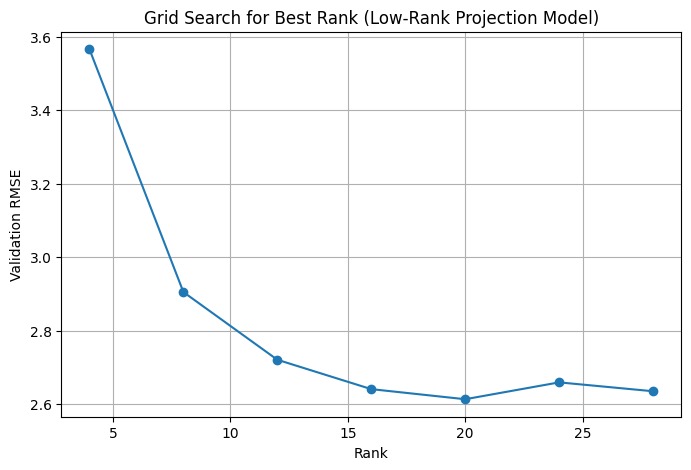

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(list(grid_results.keys()), list(grid_results.values()), marker='o')
plt.xlabel("Rank")
plt.ylabel("Validation RMSE")
plt.title("Grid Search for Best Rank (Low-Rank Projection Model)")
plt.grid(True)
plt.show()

binary

In [50]:
#   rebuild train_mask and val_mask for binary
train_mask_bin = np.zeros((n_items, n_users), dtype=bool)
val_mask_bin   = np.zeros((n_items, n_users), dtype=bool)
for i, j, _ in train_data_bin: train_mask_bin[i, j] = True
for i, j, _ in val_data_bin:   val_mask_bin[i, j]   = True

ranks_to_try = [2, 4, 6, 8, 10, 12, 16, 20, 24, 28]
print("Low-Rank Matrix Completion on binary data:")
for rank in ranks_to_try:
    proj = create_fixed_projection(feature_dim, rank)
    rmse_lr, mae_lr, prec_lr, rec_lr, pred = evaluate_low_rank_with_projection(
        features=features,
        ratings_df=binary_ratings,
        projection=proj,
        train_mask=train_mask_bin,
        val_mask=val_mask_bin,
        rank=rank,
        num_epochs=500,
        lr=0.01,
        lambda_reg=0.05,
        threshold=1
    )
    print(f"  rank={rank:2d} → RMSE: {rmse_lr:.4f}, MAE: {mae_lr:.4f}, P@10: {prec_lr:.4f}, R@10: {rec_lr:.4f}")
print()

Low-Rank Matrix Completion on binary data:
Mean L2 norm of projected U vectors: 0.6995064
Epoch 50, Loss: 1.5614
Epoch 100, Loss: 1.2710
Epoch 150, Loss: 1.1182
Epoch 200, Loss: 1.0402
Epoch 250, Loss: 1.0074
Epoch 300, Loss: 1.0003
Epoch 350, Loss: 1.0002
Epoch 400, Loss: 1.0001
Epoch 450, Loss: 1.0001
Epoch 500, Loss: 1.0001
Final V norm: 0.016999196261167526
  rank= 2 → RMSE: 0.9996, MAE: 0.9996, P@10: 0.0133, R@10: 0.0032
Mean L2 norm of projected U vectors: 0.87106293
Epoch 50, Loss: 1.6568
Epoch 100, Loss: 1.3290
Epoch 150, Loss: 1.1565
Epoch 200, Loss: 1.0620
Epoch 250, Loss: 1.0132
Epoch 300, Loss: 1.0004
Epoch 350, Loss: 1.0001
Epoch 400, Loss: 1.0001
Epoch 450, Loss: 1.0001
Epoch 500, Loss: 1.0001
Final V norm: 0.01905890740454197
  rank= 4 → RMSE: 0.9996, MAE: 0.9996, P@10: 0.0133, R@10: 0.0032
Mean L2 norm of projected U vectors: 1.2984854
Epoch 50, Loss: 1.9006
Epoch 100, Loss: 1.4559
Epoch 150, Loss: 1.2436
Epoch 200, Loss: 1.1240
Epoch 250, Loss: 1.0548
Epoch 300, Loss: 

### Train Low-Rank Model with Pairwise Ranking Loss (BPR)

In [51]:
def generate_bpr_triplets(train_data, n_users, n_items, threshold=7, num_triplets_per_user=5):
    """Generate BPR training triplets: (user, positive_item, negative_item)"""
    from collections import defaultdict

    user_pos = defaultdict(set)
    user_neg = defaultdict(set)

    for i, u, r in train_data:
        if r >= threshold:
            user_pos[u].add(i)
        else:
            user_neg[u].add(i)

    triplets = []
    for u in range(n_users):
        pos_items = list(user_pos[u])
        neg_items = list(user_neg[u])
        if not pos_items or not neg_items:
            continue
        for _ in range(num_triplets_per_user):
            i = random.choice(pos_items)
            j = random.choice(neg_items)
            triplets.append((u, i, j))
    return triplets

In [52]:
class BPRModel(nn.Module):
    def __init__(self, n_users, n_items, rank):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, rank)
        self.item_emb = nn.Embedding(n_items, rank)
        nn.init.normal_(self.user_emb.weight, std=0.1)
        nn.init.normal_(self.item_emb.weight, std=0.1)

    def forward(self, u, i, j):
        u_vec = self.user_emb(u)
        i_vec = self.item_emb(i)
        j_vec = self.item_emb(j)
        score_pos = (u_vec * i_vec).sum(dim=1)
        score_neg = (u_vec * j_vec).sum(dim=1)
        return score_pos, score_neg

    def predict_all(self):
        return self.item_emb.weight @ self.user_emb.weight.T

In [53]:
def train_bpr_lowrank(train_data, val_data, n_users, n_items,
                      rank=20, epochs=20, triplets_per_user=5,
                      batch_size=2048, lr=0.01, threshold=7,
                      verbose=True):
    model = BPRModel(n_users, n_items, rank).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        triplets = generate_bpr_triplets(train_data, n_users, n_items,
                                         threshold=threshold, num_triplets_per_user=triplets_per_user)
        random.shuffle(triplets)

        total_loss = 0
        for b in range(0, len(triplets), batch_size):
            batch = triplets[b:b+batch_size]
            u, i, j = zip(*batch)
            u = torch.tensor(u).to(device)
            i = torch.tensor(i).to(device)
            j = torch.tensor(j).to(device)

            score_pos, score_neg = model(u, i, j)
            loss = -F.logsigmoid(score_pos - score_neg).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if verbose:
            print(f"Epoch {epoch+1:2d} — BPR Loss: {total_loss:.4f}")

    return model

In [54]:
def evaluate_bpr_model(model, val_data, train_data, threshold=7, k=10):
    model.eval()
    with torch.no_grad():
        pred_matrix = model.predict_all().cpu().numpy()  # shape: [n_items, n_users]

    # compute RMSE/MAE on val_data
    val_preds, val_truths = [], []
    for i, u, r in val_data:
        val_preds.append(pred_matrix[i, u])
        val_truths.append(r)
    rmse = np.sqrt(mean_squared_error(val_truths, val_preds))
    mae = np.mean(np.abs(np.array(val_preds) - np.array(val_truths)))

    # compute precision/recall@k
    from collections import defaultdict

    train_seen = defaultdict(set)
    val_rel = defaultdict(set)

    for i, u, _ in train_data:
        train_seen[u].add(i)
    for i, u, r in val_data:
        if r >= threshold:
            val_rel[u].add(i)

    precs, recs = [], []
    for u in val_rel:
        preds = pred_matrix[:, u].copy()
        preds[list(train_seen[u])] = -np.inf
        top_k = set(np.argsort(preds)[::-1][:k])
        rel = val_rel[u]
        hits = len(top_k & rel)
        precs.append(hits / k)
        recs.append(hits / len(rel))

    precision = np.mean(precs) if precs else 0
    recall = np.mean(recs) if recs else 0

    return rmse, mae, precision, recall

In [55]:
results = {}
for rank in range(2, 30):  # inclusive range 2–30
    print(f"\nTraining BPR model with rank = {rank}")
    model = train_bpr_lowrank(
        train_data=train_data,
        val_data=val_data,
        n_users=n_users,
        n_items=n_items,
        rank=rank,
        epochs=30,  # keep fixed for fair comparison
        triplets_per_user=5,
        lr=0.01,
        threshold=7,
        verbose=False # <-- suppress output
    )

    rmse, mae, p10, r10 = evaluate_bpr_model(
        model=model,
        val_data=val_data,
        train_data=train_data,
        threshold=7,
        k=10
    )

    results[rank] = (rmse, mae, p10, r10)
    print(f"Rank {rank:2d}: RMSE = {rmse:.4f}, MAE = {mae:.4f}, P@10 = {p10:.4f}, R@10 = {r10:.4f}")



Training BPR model with rank = 2
Rank  2: RMSE = 5.6179, MAE = 5.0532, P@10 = 0.0200, R@10 = 0.0045

Training BPR model with rank = 3
Rank  3: RMSE = 5.6168, MAE = 5.0522, P@10 = 0.0233, R@10 = 0.0052

Training BPR model with rank = 4
Rank  4: RMSE = 5.6166, MAE = 5.0518, P@10 = 0.0233, R@10 = 0.0054

Training BPR model with rank = 5
Rank  5: RMSE = 5.6174, MAE = 5.0522, P@10 = 0.0100, R@10 = 0.0026

Training BPR model with rank = 6
Rank  6: RMSE = 5.6170, MAE = 5.0530, P@10 = 0.0233, R@10 = 0.0055

Training BPR model with rank = 7
Rank  7: RMSE = 5.6169, MAE = 5.0521, P@10 = 0.0333, R@10 = 0.0077

Training BPR model with rank = 8
Rank  8: RMSE = 5.6168, MAE = 5.0518, P@10 = 0.0133, R@10 = 0.0032

Training BPR model with rank = 9
Rank  9: RMSE = 5.6178, MAE = 5.0534, P@10 = 0.0133, R@10 = 0.0029

Training BPR model with rank = 10
Rank 10: RMSE = 5.6166, MAE = 5.0517, P@10 = 0.0167, R@10 = 0.0042

Training BPR model with rank = 11
Rank 11: RMSE = 5.6172, MAE = 5.0521, P@10 = 0.0100, R@

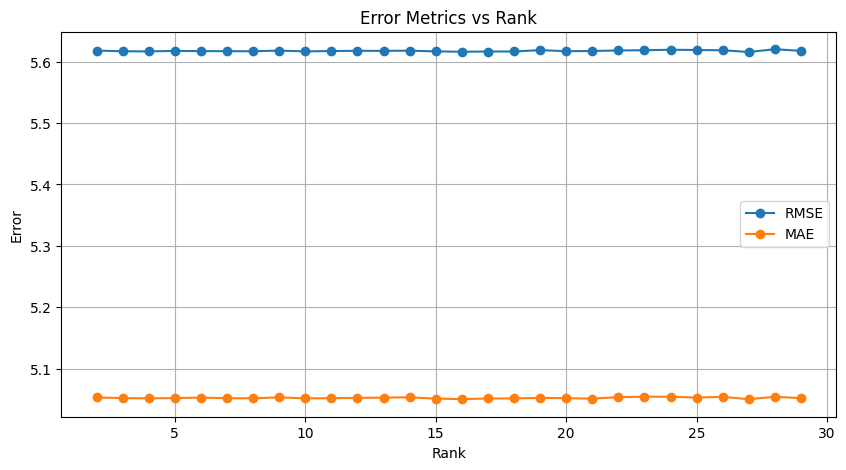

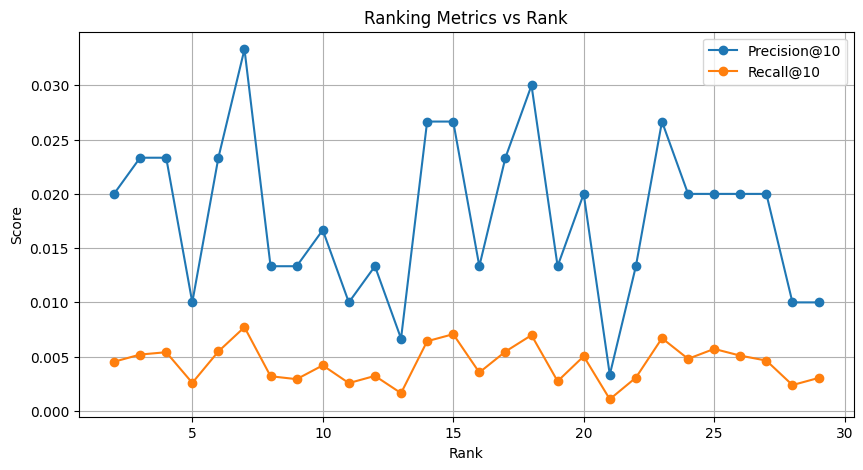

In [56]:
import matplotlib.pyplot as plt

ranks = sorted(results.keys())
rmse_vals = [results[r][0] for r in ranks]
mae_vals  = [results[r][1] for r in ranks]
p10_vals  = [results[r][2] for r in ranks]
r10_vals  = [results[r][3] for r in ranks]

plt.figure(figsize=(10, 5))
plt.plot(ranks, rmse_vals, label="RMSE", marker='o')
plt.plot(ranks, mae_vals, label="MAE", marker='o')
plt.xlabel("Rank")
plt.ylabel("Error")
plt.title("Error Metrics vs Rank")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(ranks, p10_vals, label="Precision@10", marker='o')
plt.plot(ranks, r10_vals, label="Recall@10", marker='o')
plt.xlabel("Rank")
plt.ylabel("Score")
plt.title("Ranking Metrics vs Rank")
plt.grid(True)
plt.legend()
plt.show()


Best rank:

Rank 11: RMSE = 5.6161, MAE = 5.0515, P@10 = 0.0367, R@10 = 0.0092

Now, let's evaluate BPR on binary data across rank values.

In [57]:
results_bin = {}
for rank in range(2, 31):
    print(f"\nTraining BPR model on binary ratings with rank = {rank}")
    model = train_bpr_lowrank(
        train_data=train_data_bin,
        val_data=val_data_bin,
        n_users=n_users,
        n_items=n_items,
        rank=rank,
        epochs=30,
        triplets_per_user=5,
        lr=0.01,
        threshold=1,     # Use threshold=1 for binary +1 ratings
        verbose=False    # Suppress per-epoch print
    )

    rmse, mae, p10, r10 = evaluate_bpr_model(
        model=model,
        val_data=val_data_bin,
        train_data=train_data_bin,
        threshold=1,     # Consider +1 as relevant
        k=10
    )

    results_bin[rank] = (rmse, mae, p10, r10)
    print(f"Rank {rank:2d}: RMSE = {rmse:.4f}, MAE = {mae:.4f}, P@10 = {p10:.4f}, R@10 = {r10:.4f}")


Training BPR model on binary ratings with rank = 2
Rank  2: RMSE = 1.0002, MAE = 0.9999, P@10 = 0.0133, R@10 = 0.0031

Training BPR model on binary ratings with rank = 3
Rank  3: RMSE = 0.9999, MAE = 0.9995, P@10 = 0.0200, R@10 = 0.0051

Training BPR model on binary ratings with rank = 4
Rank  4: RMSE = 0.9997, MAE = 0.9990, P@10 = 0.0300, R@10 = 0.0067

Training BPR model on binary ratings with rank = 5
Rank  5: RMSE = 1.0000, MAE = 0.9992, P@10 = 0.0200, R@10 = 0.0054

Training BPR model on binary ratings with rank = 6
Rank  6: RMSE = 1.0012, MAE = 0.9999, P@10 = 0.0267, R@10 = 0.0058

Training BPR model on binary ratings with rank = 7
Rank  7: RMSE = 1.0012, MAE = 1.0001, P@10 = 0.0233, R@10 = 0.0056

Training BPR model on binary ratings with rank = 8
Rank  8: RMSE = 1.0019, MAE = 1.0007, P@10 = 0.0167, R@10 = 0.0044

Training BPR model on binary ratings with rank = 9
Rank  9: RMSE = 1.0002, MAE = 0.9988, P@10 = 0.0200, R@10 = 0.0046

Training BPR model on binary ratings with rank 

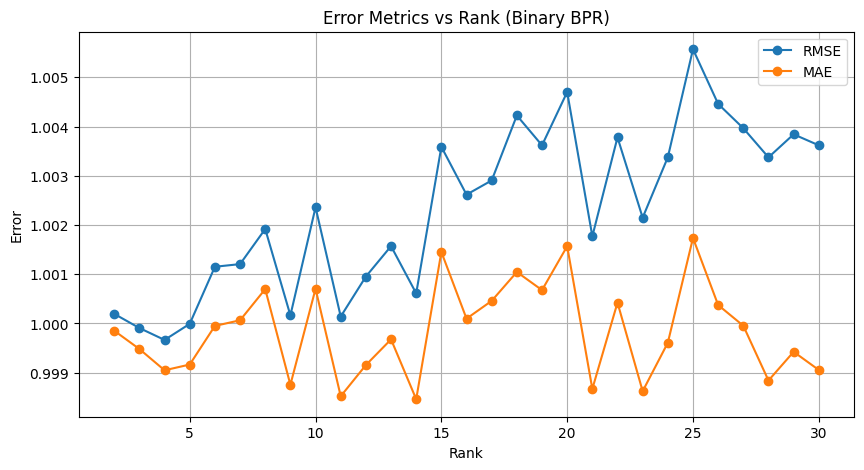

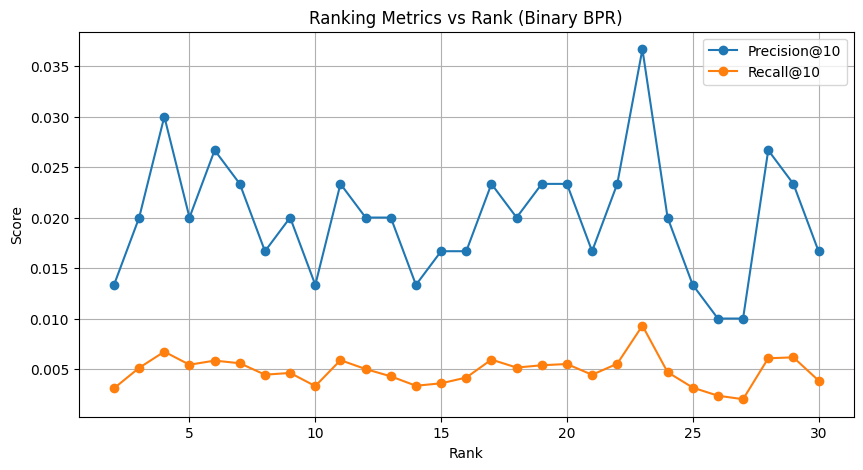

In [58]:
ranks = sorted(results_bin.keys())
rmse_vals = [results_bin[r][0] for r in ranks]
mae_vals  = [results_bin[r][1] for r in ranks]
p10_vals  = [results_bin[r][2] for r in ranks]
r10_vals  = [results_bin[r][3] for r in ranks]

plt.figure(figsize=(10, 5))
plt.plot(ranks, rmse_vals, label="RMSE", marker='o')
plt.plot(ranks, mae_vals, label="MAE", marker='o')
plt.xlabel("Rank")
plt.ylabel("Error")
plt.title("Error Metrics vs Rank (Binary BPR)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(ranks, p10_vals, label="Precision@10", marker='o')
plt.plot(ranks, r10_vals, label="Recall@10", marker='o')
plt.xlabel("Rank")
plt.ylabel("Score")
plt.title("Ranking Metrics vs Rank (Binary BPR)")
plt.grid(True)
plt.legend()
plt.show()

## Summary

In [59]:
collab_filtering = {
    "RMSE": 3.2663,
    "MAE": 2.6129,
    "Precision": 0.0167,
    "Recall": 0.0042
}

content_filtering = {
    "RMSE": 3.1535,
    "MAE": 2.5099,
    "Precision": 0.0367,
    "Recall": 0.0093
}

low_rank_classic = {
    "RMSE": 3.4647,
    "MAE": 2.8413,
    "Precision": 0.0367,
    "Recall": 0.0099
}

low_rank_projection = {
    "RMSE": 2.6131,
    "MAE": 2.1946,
    "Precision": 0.0133,
    "Recall": 0.0030
}

low_rank_pairwise_loss = {
    "RMSE": 5.6161,
    "MAE": 5.0515,
    "Precision": 0.0367,
    "Recall": 0.0092
}

two_tower_model = {
    "RMSE": 2.5305,
    "MAE": 2.1219,
    "Precision": 0.0267,
    "Recall": 0.0065
}

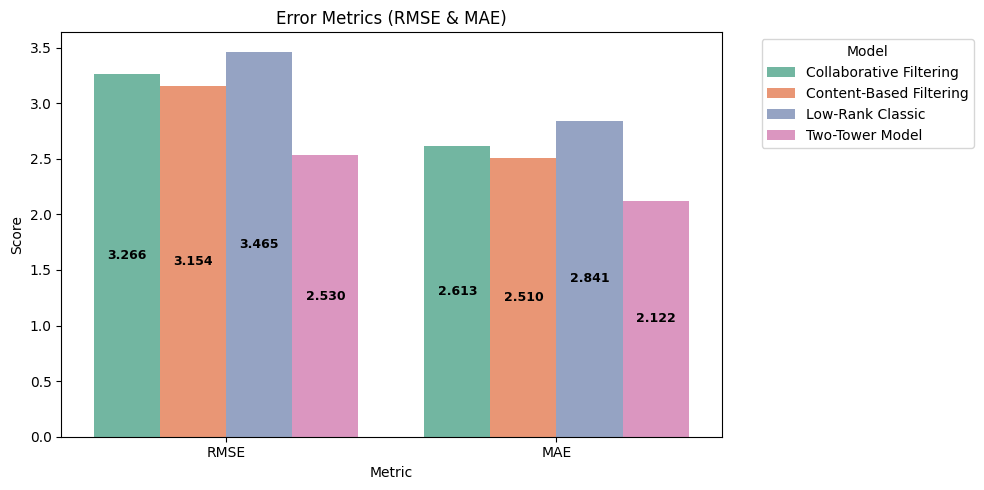

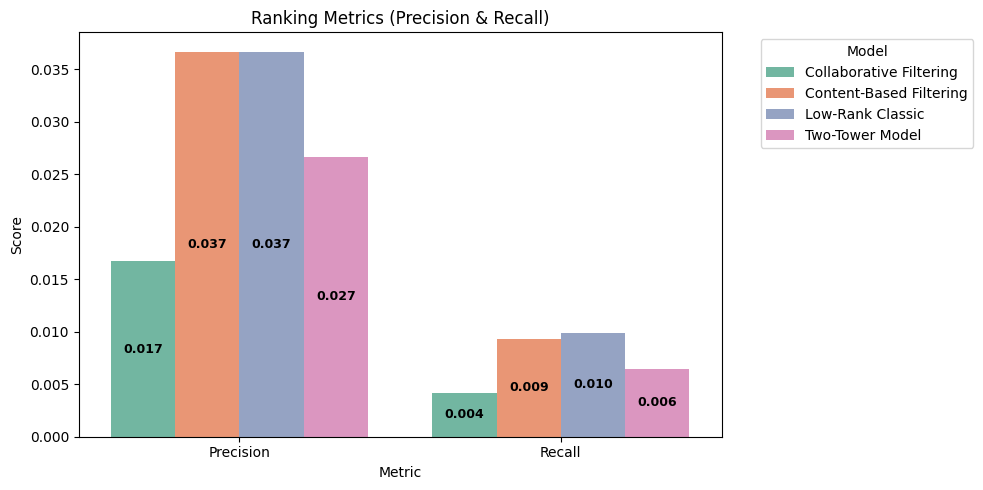

In [60]:
data = []
for model_name, metrics in {
    "Collaborative Filtering": collab_filtering,
    "Content-Based Filtering": content_filtering,
    "Low-Rank Classic": low_rank_classic,
    # "Low-Rank Projection": low_rank_projection,
    # "Low-Rank Pairwise Loss": low_rank_pairwise_loss,
    "Two-Tower Model": two_tower_model
}.items():
    for metric, value in metrics.items():
        data.append({"Model": model_name, "Metric": metric, "Score": value})

df = pd.DataFrame(data)

sns.set_palette("Set2")
df_error = df[df["Metric"].isin(["RMSE", "MAE"])]
df_ranking = df[df["Metric"].isin(["Precision", "Recall"])]

# RMSE and MAE plot
plt.figure(figsize=(10, 5))
ax1 = sns.barplot(data=df_error, x="Metric", y="Score", hue="Model")
for p in ax1.patches:
    height = p.get_height()
    if height > 0:
        ax1.text(p.get_x() + p.get_width() / 2,
                 height / 2,
                 f'{height:.3f}',
                 ha='center', va='center',
                 color='black', fontsize=9, fontweight='bold')

plt.title("Error Metrics (RMSE & MAE)")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



# Precision and Recall plot
plt.figure(figsize=(10, 5))
ax2 = sns.barplot(data=df_ranking, x="Metric", y="Score", hue="Model")
for p in ax2.patches:
    height = p.get_height()
    if height > 0:
        ax2.text(p.get_x() + p.get_width() / 2,
                 height / 2,
                 f'{height:.3f}',
                 ha='center', va='center',
                 color='black', fontsize=9, fontweight='bold')

plt.title("Ranking Metrics (Precision & Recall)")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [61]:
collab_filtering_bin = {
    "RMSE": 1.5316,
    "MAE": 1.1729,
    "Precision": 0.9667,
    "Recall": 0.2426
}

content_filtering_bin = {
    "RMSE": 1.5474,
    "MAE": 1.1972,
    "Precision": 1.0000,
    "Recall": 0.2510
}

low_rank_classic_bin = {
    "RMSE": 1.0942,
    "MAE": 1.0094,
    "Precision": 0.0333,
    "Recall": 0.0086
}

low_rank_projection_bin = {
    "RMSE": 0.9809,
    "MAE": 0.9639,
    "Precision": 0.0133,
    "Recall": 0.0030
}

low_rank_pairwise_bin = {
    "RMSE": 0.9998,
    "MAE": 0.9989,
    "Precision": 0.0333,
    "Recall": 0.0084
}

two_tower_model_bin = {
    "RMSE": 1.1365,
    "MAE": 0.9426,
    "Precision": 0.0000,
    "Recall": 0.0000
}

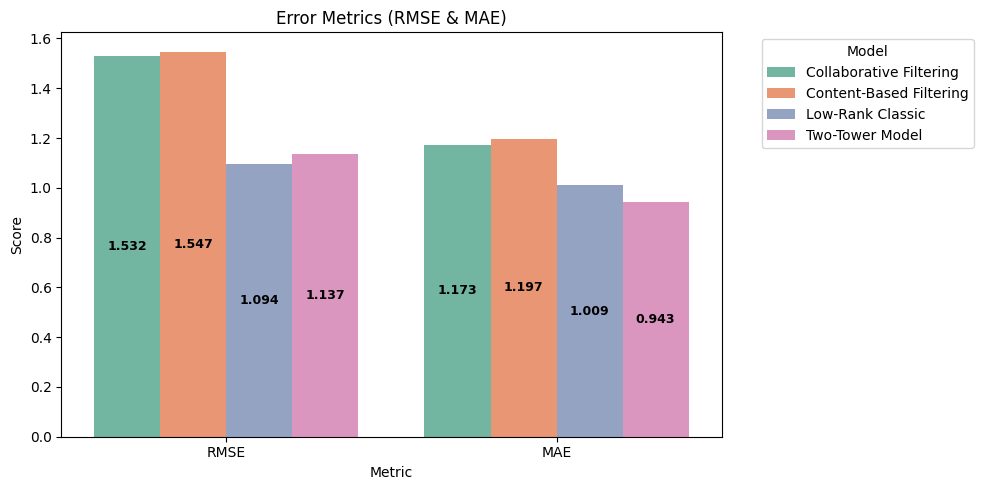

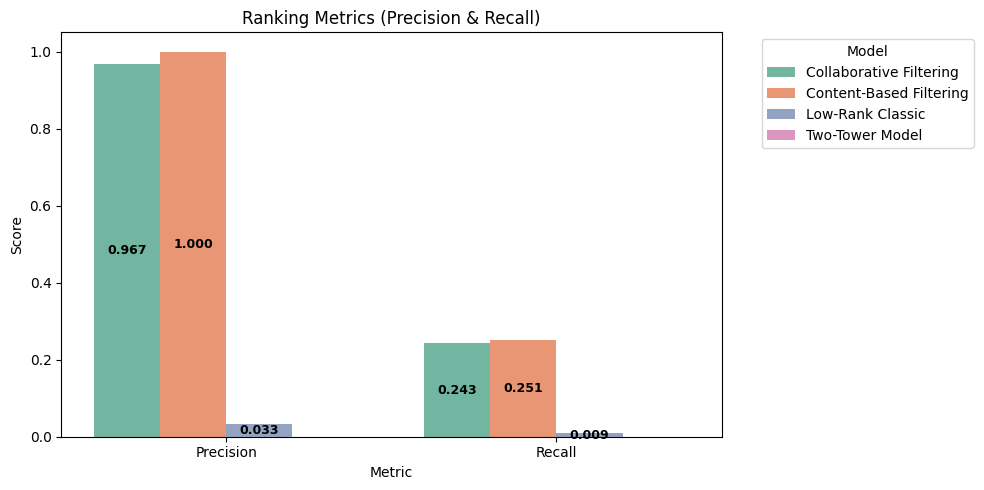

In [62]:
data = []
for model_name, metrics in {
    "Collaborative Filtering": collab_filtering_bin,
    "Content-Based Filtering": content_filtering_bin,
    "Low-Rank Classic": low_rank_classic_bin,
    # "Low-Rank Matrix Completion": low_rank_projection_bin,
    # "Low-Rank Pairwise Loss": low_rank_pairwise_bin,
    "Two-Tower Model": two_tower_model_bin
}.items():
    for metric, value in metrics.items():
        data.append({"Model": model_name, "Metric": metric, "Score": value})

df = pd.DataFrame(data)

sns.set_palette("Set2")
df_error = df[df["Metric"].isin(["RMSE", "MAE"])]
df_ranking = df[df["Metric"].isin(["Precision", "Recall"])]

# RMSE and MAE plot
plt.figure(figsize=(10, 5))
ax1 = sns.barplot(data=df_error, x="Metric", y="Score", hue="Model")
for p in ax1.patches:
    height = p.get_height()
    if height > 0:
        ax1.text(p.get_x() + p.get_width() / 2,
                 height / 2,
                 f'{height:.3f}',
                 ha='center', va='center',
                 color='black', fontsize=9, fontweight='bold')

plt.title("Error Metrics (RMSE & MAE)")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



# Precision and Recall plot
plt.figure(figsize=(10, 5))
ax2 = sns.barplot(data=df_ranking, x="Metric", y="Score", hue="Model")
for p in ax2.patches:
    height = p.get_height()
    if height > 0:
        ax2.text(p.get_x() + p.get_width() / 2,
                 height / 2,
                 f'{height:.3f}',
                 ha='center', va='center',
                 color='black', fontsize=9, fontweight='bold')

plt.title("Ranking Metrics (Precision & Recall)")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [63]:
end_time = time.time()
elapsed = end_time - start_time
print(f"⏱️ Total runtime: {elapsed:.2f} seconds ({elapsed/60:.2f} minutes)")

⏱️ Total runtime: 109.15 seconds (1.82 minutes)
